In [2]:
from utils.toy_utils import *
from utils.visualization import *

In [12]:
paras = {'constraint':  [Complex_Constraints(), Disconnected_Ball()][1], 
            'fix_input': False,
            'fixed_margin': False, 
            'gamma': 1e-3, }
paras['proj_para'] = {'corrTestMaxSteps': 100, 'corrEps': 1e-5, 'corrBis':0.5}

In [13]:
fixed_margin = paras['fixed_margin']
gamma = paras['gamma']
fix_input = paras['fix_input']
instance = f'fix_{fix_input}_ecc_{fixed_margin}_{gamma}'
data = paras['constraint']
n_dim = 2
c_dim = data.c_dim
data.to_device(DEVICE)

In [14]:
instance_path = f'results/toy_example/BP/{str(data)}'
instance = f'fix_{fix_input}_ecc_{fixed_margin}_{gamma}'
dist_list = []
loss_list = []
valid_list = []
for exper_id in range(1):
    training_record = np.load(instance_path + f'/nns/{exper_id}_training_record_{instance}.npy', allow_pickle=True).item()  
    loss_data = training_record['perturbed_penalty_loss']
    eccentricity_list = training_record['point_to_boudanry_dist']
    valid_rate = training_record['valid_rate_list']
    dist_list.append(eccentricity_list)
    loss_list.append(loss_data)
    valid_list.append(valid_rate)
dist_list = np.stack(dist_list, axis=0)
dist_list_mean = np.mean(dist_list, axis=0)
dist_list_std = np.std(dist_list, axis=0)

loss_list = np.stack(loss_list, axis=0)
loss_list_mean = np.mean(loss_list, axis=0)
loss_list_std = np.std(loss_list, axis=0)


valid_list = np.stack(valid_list, axis=0) * 100
valid_list_mean = np.mean(valid_list, axis=0)
valid_list_std = np.std(valid_list, axis=0)

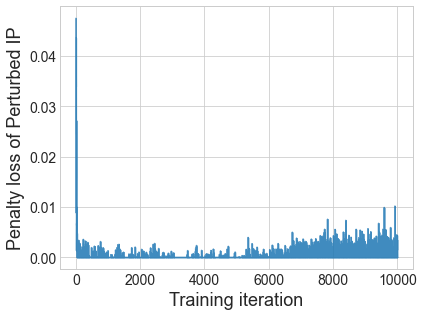

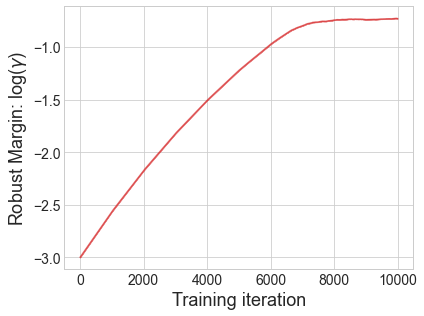

In [15]:
plt.style.use('seaborn-whitegrid')  # White grid background
plt.rcParams['axes.axisbelow'] = True  # This specifically puts grid below data

total_iteration = np.arange(loss_list_mean.shape[1])
ylabel_list = ['Penalty loss of Perturbed IP', r'Robust Margin: log($\gamma$)']
title_list = ['penalty', 'gamma']
line_style_list = ['-', '-', '-']
color_list = ['C0', 'C3']
for i in range(loss_list_mean.shape[0]):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(total_iteration, loss_list_mean[i], label=ylabel_list[i], alpha=0.7, linestyle=line_style_list[i], color=color_list[i])
    ax.fill_between(total_iteration, loss_list_mean[i] - loss_list_std[i], loss_list_mean[i] + loss_list_std[i], alpha=0.5,color=color_list[i])
    
    ax.set_xlabel('Training iteration', fontsize=18)
    ax.set_ylabel(ylabel_list[i], fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.xscale('log')
    # plt.grid(True, alpha=0.9, linewidth=1, linestyle=':')
    plt.tight_layout()
    plt.savefig(f'results/toy_example/BP/{str(data)}/pics/{title_list[i]}', dpi=300)

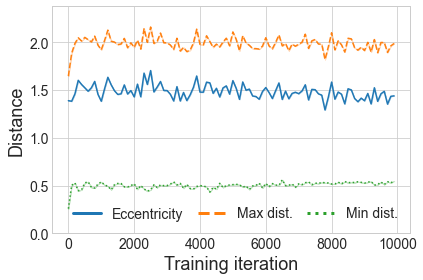

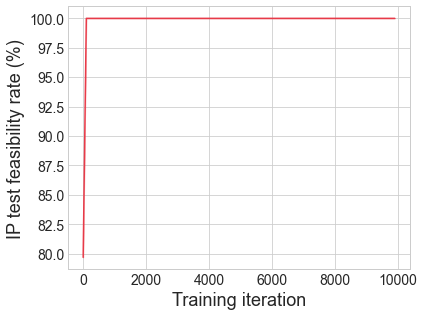

In [16]:
plt.style.use('seaborn-whitegrid')  # White grid background
plt.rcParams['axes.axisbelow'] = True  # This specifically puts grid below data

total_iteration = (np.arange(dist_list_mean.shape[1]) * 100) + 1
line_style_list = ['-', '--', ':']
color_list = ['C0', 'C1','C2']
plt.figure(figsize=[6, 4])
ylabel_list = ['Eccentricity', 'Max dist.', 'Min dist.']
for i in range(dist_list_mean.shape[0]):
    plt.plot(total_iteration, dist_list_mean[i], alpha=0.99, linestyle=line_style_list[i], color=color_list[i])
    plt.fill_between(total_iteration, dist_list_mean[i] - dist_list_std[i], dist_list_mean[i] + dist_list_std[i], alpha=0.25,color=color_list[i])
    plt.plot([], [], label=ylabel_list[i], linewidth=3 ,alpha=1, linestyle=line_style_list[i], color=color_list[i])

plt.legend(fontsize=14, ncol=3, columnspacing=1.0, loc=4)
plt.xlabel('Training iteration', fontsize=18)
plt.ylabel('Distance', fontsize=18)
# plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, dist_list_mean.max()*1.1])
# plt.grid(True, alpha=0.9, linewidth=1, linestyle=':')
plt.tight_layout()
plt.savefig(f'results/toy_example/BP/{str(data)}/pics/eccentricity_dist', dpi=300)


plt.figure(figsize=[6, 4.5])
plt.plot(total_iteration, valid_list_mean, label=ylabel_list[i], alpha=0.99, color='#E83947')
plt.fill_between(total_iteration, valid_list_mean - valid_list_std, valid_list_mean + valid_list_std, color='#E83947', alpha=0.25)
plt.xlabel('Training iteration', fontsize=18)
plt.ylabel('IP test feasibility rate (%)', fontsize=18)
# plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(True, alpha=0.9, linewidth=1, linestyle=':')
plt.tight_layout()
plt.savefig(f'results/toy_example/BP/{str(data)}/pics/feasibility_rate', dpi=300)

In [ ]:
def plot_bp_traj_varying_input(data, paras, instance_path, instance, n_dim, c_dim, num_test=3, err=0.2, density=10, seed=2025):
    """
    Bisection projection traj under different number of inputs
    """
    model = torch.load(instance_path + f'/nns/model_{instance}.pth', map_location=data.device)

    if paras['fix_input']:
        c_sample = data.fix_c
    else:
        if 'Ball' in instance_path:
            np.random.seed(seed)
        else:
            np.random.seed(seed)
        c = np.random.rand(num_test, c_dim)
        c_sample = c * (data.sampling_range[1] - data.sampling_range[0]) + data.sampling_range[0]

    plt.style.use('seaborn-whitegrid')  # White grid background
    plt.rcParams['axes.axisbelow'] = True  # This specifically puts grid below data
    fig = plt.figure(figsize=[(num_test)*(4+0.2), 4.2])

    title_list = [f'test input {i}' for i in range(1,10)]
    for i in range(num_test):
        ct = c_sample[[i]]
        # modified infeasible sampling method
        x_tensor = data.sampling_infeasible(ct,err,density).to(data.device)
        c_tensor = torch.as_tensor(ct).to(data.device).view(1,-1)
        model.eval()
        with torch.no_grad():
            ip = model(c_tensor).view(-1, 1, n_dim)
        x_infeasible, x_feasible, ip_near, ip = plot_bp_traj(data, ip, c_tensor, x_tensor, paras)
        
        plt.subplot(1, num_test, i + 1)
        data.fill_constraint(ct)
        for j in range(x_infeasible.shape[0]):
            plt.plot([x_infeasible[j, 0], x_feasible[j, 0]], [x_infeasible[j, 1], x_feasible[j, 1]],
                     linewidth=0.5, alpha=0.5, c='lightcoral')
        plt.scatter(ip[:, 0], ip[:, 1], marker='*', c='crimson')
        plt.scatter(x_infeasible[:, 0], x_infeasible[:, 1], c = 'C1',alpha=0.5, s=20)
        plt.scatter(x_feasible[:, 0], x_feasible[:, 1], c='C0', alpha=0.5, s=20)
        plt.xlim([-2., 2.])
        plt.ylim([-2., 2.])
        plt.title(title_list[i], fontsize=19)
    
    plt.scatter([],[], marker='*', c='crimson', s=50, label='Interior points')
    plt.scatter([],[], c = 'C1',alpha=0.7, s=50, label='Infeasible points')
    plt.scatter([],[], c='C0', alpha=0.7, s=50, label='Projected points')
    fig.legend(fontsize=17, ncol=3, bbox_to_anchor=[0.65, 0.1], framealpha=1)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)    
    plt.savefig(instance_path + f'/pics/bis_{num_test}_{instance}.png', dpi=300)
    plt.show()
    plt.close()


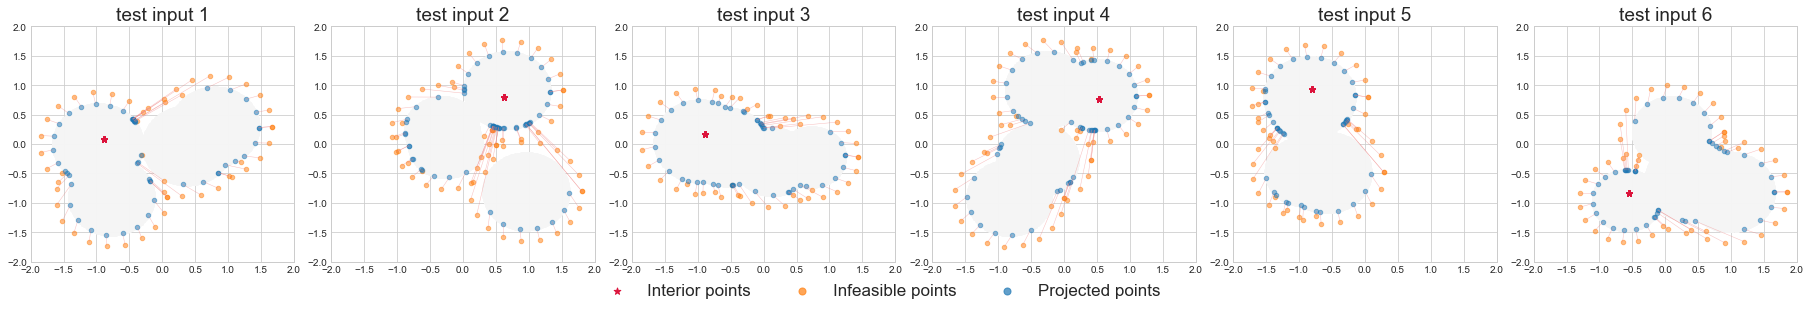

In [18]:
data.device = DEVICE
instance_path = f'results/toy_example/BP/{str(data)}'
instance = f'fix_{fix_input}_ecc_{fixed_margin}_{gamma}'
paras['proj_para'] = {'corrTestMaxSteps': 100, 'corrEps': 1e-5, 'corrBis':0.9}

plot_bp_traj_varying_input(data, paras, instance_path, instance, n_dim, c_dim, num_test=6, seed=2022)

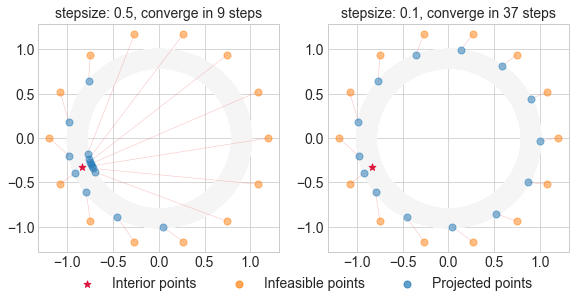

In [11]:
data = RingSet(inner_radius=0.8, outer_radius=1.0)
data.to_device(DEVICE)

plt.rcParams['axes.axisbelow'] = True  # This specifically puts grid below data
plt.style.use('seaborn-whitegrid')  # White grid background
fig = plt.figure(figsize=[(3)*(4+0.9), 4.2])
for i, bis_step in enumerate([0.5, 0.9]):
    
    theta = np.pi * 1.12
    ip = torch.tensor([[0.9*np.cos(theta), 0.9*np.sin(theta)]])
    eps = 1e-3

    err=0.2
    density=15
    x_tensor = data.sampling_infeasible(None,err,density).to(data.device)
    x_infeasible = x_tensor

    batch_size = x_infeasible.shape[0]
    alpha_lower = torch.zeros(size=[batch_size, 1])
    alpha_upper = torch.ones(size=[batch_size, 1])
    for k in range(100):
        alpha = (1-bis_step)*alpha_lower + bis_step*alpha_upper
        xt = alpha * (x_infeasible - ip) + ip
        violation = data.check_feasibility(None, xt)
        penalty = torch.sum(torch.abs(violation), dim=-1)
        sub_feasible_index = (penalty < eps).view(-1)
        sub_infeasible_index = (penalty >= eps).view(-1)
        alpha_lower[sub_feasible_index] = alpha[sub_feasible_index]
        alpha_upper[sub_infeasible_index] = alpha[sub_infeasible_index]
        if (alpha_upper-alpha_lower).max()<1e-3:
            break
    x_feasible = alpha_lower * (x_infeasible - ip) + ip

    x_infeasible = x_infeasible.cpu().numpy()
    x_feasible = x_feasible.cpu().numpy()


    # fig = plt.figure(figsize=[6, 6])
    plt.subplot(1,3,i+1)
    data.fill_constraint(c=None)
    # data.plot_boundary(c=None)
    for j in range(x_infeasible.shape[0]):
        plt.plot([x_infeasible[j, 0], x_feasible[j, 0]], [x_infeasible[j, 1], x_feasible[j, 1]],
                    linewidth=0.5, alpha=0.5, c='lightcoral')
    plt.scatter(x_feasible[:, 0], x_feasible[:, 1], alpha=0.5, s=50, zorder=3)
    plt.scatter(x_infeasible[:, 0], x_infeasible[:, 1], alpha=0.5, s=50, zorder=3)
    plt.scatter(ip[:, 0], ip[:, 1], marker='*', c='crimson', s=50, zorder=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'stepsize: {1-bis_step:.1f}, converge in {k} steps', fontsize=14)


plt.scatter([],[], marker='*', c='crimson', s=50, label='Interior points')
plt.scatter([],[], c = 'C1',alpha=0.7, s=50, label='Infeasible points')
plt.scatter([],[], c='C0', alpha=0.7, s=50, label='Projected points')
plt.legend(fontsize=14, ncol=3, bbox_to_anchor=[0.9, -0.05], framealpha=1)

# os.makedirs(f'results/toy_example/BP/{str(data)}', exist_ok=True)
output_dir = f'results/toy_example/BP/{str(data)}'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f'{output_dir}/bis_step_sensitivity_main.png', dpi=300, bbox_inches='tight')